# Relationship Extraction

This notebook is similar to the `05-nyt-re-bert.ipynb` except that this is an implementation of scenario (f) in the slides. Instead of maxpooling over the subject and object spans, we just pull the encoding off the starting subject and object tags.

In terms of results, this performs marginally better than scenario (e), MAXPOOLing the entity spans (including the entity marker tags), even though it appears to provide less information to the classifier head to make the prediction.

Using the values from the starting span tags is faster though, so it is possible that it might be more feasible to fine tune this model for larger number of epochs to get better performance.

In [1]:
!pip install transformers datasets seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.3 MB 6.7 MB/s 
     |████████████████████████████████| 432 kB 61.3 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 163 kB 66.0 MB/s 
     |████████████████████████████████| 7.6 MB 41.5 MB/s 
     |████████████████████████████████| 115 kB 55.9 MB/s 
     |████████████████████████████████| 212 kB 57.9 MB/s 
     |████████████████████████████████| 127 kB 60.9 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=717191ec8fdf5428fba929fe4796ea4421856d792efc870450a5a820f58a4533
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.

In [2]:
!huggingface-cli login


        _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
        _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
        _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
        _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
        _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

        To login, `huggingface_hub` now requires a token generated from https://huggingface.co/settings/tokens .
        
Token: 
Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your termin

## Imports

In [3]:
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import random
import re
import shutil
import torch
import torch.nn as nn

from collections import Counter, defaultdict
from datasets import load_dataset, ClassLabel
from sklearn.metrics import (
    ConfusionMatrixDisplay, confusion_matrix, 
    classification_report, accuracy_score
)
from torch.utils.data import DataLoader, SubsetRandomSampler
from torch.optim import AdamW

from transformers import AutoTokenizer, AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import (
    BertTokenizerFast, BertModel, BertForPreTraining, BertConfig, BertPreTrainedModel,
    DataCollatorWithPadding, DataCollatorForSeq2Seq,
    get_scheduler
)
from transformers.modeling_outputs import SequenceClassifierOutput
from transformers import TrainingArguments, Trainer


import datasets
from datasets import load_dataset, load_metric

## Mount Google Drive

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
GS_INPUT_DIR = "/content/drive/MyDrive/Colab Notebooks/ER/split-data"
DATA_DIR = "/content/drive/MyDrive/Colab Notebooks/ER/split-data/transformed"

BASE_MODEL_NAME = "alexaapo/greek_legal_bert_v2"

## Input Data Format

In [6]:
with open(os.path.join(GS_INPUT_DIR, "train.json"), "r") as fin:
  for line in fin:
    rec = json.loads(line.strip())
    break

print(json.dumps(rec, indent=2, ensure_ascii = False))

{
  "sentText": "\"2. Η Γενική Διεύθυνση Δικαιοσύνης συγκροτείται από τις ακόλουθες Διευθύνσεις: α) Διεύθυνση Οργάνωσης και Λειτουργίας Δικαιοσύνης, β) Διεύθυνση Δικαστικών Υπαλλήλων, γ) Διεύθυνση Νομικών Επαγγελμάτων.\"",
  "entityMentions": [
    {
      "text": "Γενική Διεύθυνση Δικαιοσύνης συγκροτείται",
      "start": 1,
      "label": "ORG"
    },
    {
      "text": "Διεύθυνση Οργάνωσης και Λειτουργίας Δικαιοσύνης",
      "start": 2,
      "label": "ORG"
    },
    {
      "text": "Διεύθυνση Δικαστικών Υπαλλήλων",
      "start": 3,
      "label": "ORG"
    },
    {
      "text": "Διεύθυνση Νομικών Επαγγελμάτων",
      "start": 4,
      "label": "ORG"
    }
  ],
  "relationMentions": [
    {
      "em1Text": "Γενική Διεύθυνση Δικαιοσύνης συγκροτείται",
      "em2Text": "Διεύθυνση Οργάνωσης και Λειτουργίας Δικαιοσύνης",
      "label": "Org/Org/SubOrg"
    },
    {
      "em1Text": "Γενική Διεύθυνση Δικαιοσύνης συγκροτείται",
      "em2Text": "Διεύθυνση Δικαστικών Υπαλλήλων",
     

## Entity Types

In [7]:
splits = ["train", "valid", "test"]
ent_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["entityMentions"]:
        label = ent_mention["label"]
        ent_counts[label][split] += 1

ent_df = pd.DataFrame.from_dict(ent_counts, orient="index").sort_values("train", ascending=False)
ent_df

,train,valid,test
ORG,2227,289,263


## Relation Types

In [8]:
rel_counts = collections.defaultdict(collections.Counter)
for split in splits:
  with open(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)), "r") as fin:
    for json_line in fin:
      json_dict = json.loads(json_line.strip())
      for ent_mention in json_dict["relationMentions"]:
        label = ent_mention["label"].split("/")[-1]
        rel_counts[label][split] += 1

rel_df = pd.DataFrame.from_dict(rel_counts, orient="index").sort_values("train", ascending=False)
rel_df

,train,valid,test
NoRel,6222,784,869
SubOrg,1528,196,202
CoRef,210,24,10


## Raw Dataset

In [9]:
def reformat_json(infile, outfile, valid_relations):
  print("reformating {:s} -> {:s}".format(infile, outfile))
  fout = open(outfile, "w")
  with open(infile, "r") as fin:
    for line in fin:
      rec = json.loads(line.strip())
      text = rec["sentText"]
      entities = {}
      for entity_mention in rec["entityMentions"]:
        entity_text = entity_mention["text"]
        entity_type = entity_mention["label"][0:3]
        entities[entity_text] = entity_type
      for relation_mention in rec["relationMentions"]:
        label = relation_mention["label"].split("/")[-1]
        if label not in valid_relations:
          continue
        try:
          sub_text = relation_mention["em1Text"]
          sub_type = entities[sub_text]
          obj_text = relation_mention["em2Text"]
          obj_type = entities[obj_text]
          
          # assumption: em1Text == SUBJECT and occurs before em2Text == OBJECT
          sub_start = text.find(sub_text)
          sub_end = sub_start + len(sub_text)
          text_pre = text[:sub_start]
          text_sub = "<S:{:s}> {:s} </S:{:s}>".format(sub_type, sub_text, sub_type)
          obj_start = text.find(obj_text, sub_end)
          obj_end = obj_start + len(obj_text)
          text_mid = text[sub_end:obj_start]
          text_obj = "<O:{:s}> {:s} </O:{:s}>".format(obj_type, obj_text, obj_type)
          text_post = text[obj_end:]
          text2 = text_pre + text_sub + text_mid + text_obj + text_post

          tokens = text2.split()

          if label == 'SubOrg':
            label = label2id['SubOrg']
          else: 
            label = label2id['NoRel']
            
          output = {
              "tokens": tokens,
              "label": label
          }
          
          fout.write(json.dumps(output, ensure_ascii=False) + "\n")
        except:
          pass
  fout.close()


os.makedirs(DATA_DIR, exist_ok=True)

valid_relations = set([
  "SubOrg", "NoRel"])

tags = sorted(list(valid_relations))
rel_tags = ClassLabel(names=tags)
label2id = {name: rel_tags.str2int(name) for name in tags}
id2label = {id: rel_tags.int2str(id) for id in range(len(tags))}


for i, split in enumerate(splits):
  reformat_json(os.path.join(GS_INPUT_DIR, "{:s}.json".format(split)),
                os.path.join(DATA_DIR, "{:s}.json".format(split)), 
                valid_relations=valid_relations)

reformating /content/drive/MyDrive/Colab Notebooks/ER/split-data/train.json -> /content/drive/MyDrive/Colab Notebooks/ER/split-data/transformed/train.json
reformating /content/drive/MyDrive/Colab Notebooks/ER/split-data/valid.json -> /content/drive/MyDrive/Colab Notebooks/ER/split-data/transformed/valid.json
reformating /content/drive/MyDrive/Colab Notebooks/ER/split-data/test.json -> /content/drive/MyDrive/Colab Notebooks/ER/split-data/transformed/test.json


In [10]:
data_files = {split: os.path.join(DATA_DIR, "{:s}.json".format(split)) for split in splits}
nyt_dataset = load_dataset("json", data_files=data_files)
nyt_dataset

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-a309043f024a13f3/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label'],
        num_rows: 7750
    })
    valid: Dataset({
        features: ['tokens', 'label'],
        num_rows: 980
    })
    test: Dataset({
        features: ['tokens', 'label'],
        num_rows: 1071
    })
})

### Label Distribution

In [11]:
nyt_dataset.set_format(type="pandas")
nyt_df = nyt_dataset["train"][:]
nyt_df.head()

,tokens,label
0,"[""2., Η, <S:ORG>, Γενική, Διεύθυνση, Δικαιοσύν...",1
1,"[""2., Η, <S:ORG>, Γενική, Διεύθυνση, Δικαιοσύν...",1
2,"[""2., Η, <S:ORG>, Γενική, Διεύθυνση, Δικαιοσύν...",1
3,"[""2., Η, Γενική, Διεύθυνση, Δικαιοσύνης, συγκρ...",0
4,"[""2., Η, Γενική, Διεύθυνση, Δικαιοσύνης, συγκρ...",0


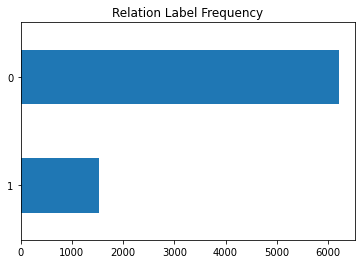

In [12]:
nyt_df["label"].value_counts(ascending=True).plot.barh()
plt.title("Relation Label Frequency")
_ = plt.show()

### Sentence Length Distribution

Box plots below shows that we can safely ignore sentences that are over 450
 tokens in length.

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


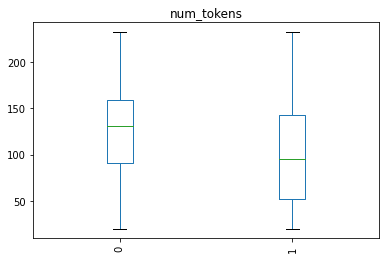

In [13]:
nyt_df["num_tokens"] = nyt_df["tokens"].apply(len)
nyt_df.boxplot("num_tokens", by="label", grid=False, showfliers=False)
plt.suptitle("")
plt.xlabel("")
plt.xticks(rotation=90)
_ = plt.show()

In [14]:
nyt_dataset.reset_format()

## Tokenizer

In [15]:
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/459 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/509k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/89.0 [00:00<?, ?B/s]

### Add Entity Marker Tokens

In [16]:
marker_tokens = []
entity_types = ["ORG"]
for entity_type in entity_types:
  marker_tokens.append("<S:{:s}>".format(entity_type))
  marker_tokens.append("</S:{:s}>".format(entity_type))
  marker_tokens.append("<O:{:s}>".format(entity_type))
  marker_tokens.append("</O:{:s}>".format(entity_type))

tokenizer.add_tokens(marker_tokens)

4

## Encoded Dataset

In [17]:
def tokenize_function(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True, max_length=420,
    )
    
    tokenized_inputs["labels"] = examples["label"]

    return tokenized_inputs

In [18]:
tokenized_datasets = nyt_dataset.map(tokenize_function, batched=True)

  0%|          | 0/8 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

In [19]:
tokenized_datasets 

DatasetDict({
    train: Dataset({
        features: ['tokens', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7750
    })
    valid: Dataset({
        features: ['tokens', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 980
    })
    test: Dataset({
        features: ['tokens', 'label', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1071
    })
})

In [20]:
data_col = DataCollatorWithPadding(tokenizer=tokenizer)

In [21]:
BATCH_SIZE = 16

## Model

## Metrics

In [22]:
def safe_div(num, denom):
    if denom > 0:
        return num / denom
    else:
        return 0
        
def compute_f1(predicted, gold, matched):
    precision = safe_div(matched, predicted)
    recall = safe_div(matched, gold)
    f1 = safe_div(2 * precision * recall, precision + recall)
    return precision, recall, f1

def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [id2label[label] for label in labels]
    true_predictions = [id2label[pred] for pred in predictions]

    num_gold_relation = 0
    num_pred_relation = 0
    num_match = 0

    for t, p in zip(true_labels, true_predictions):
        if t != 'O':
            num_gold_relation += 1
        if p != 'O':
            num_pred_relation += 1
        if t != 'O' and p != 'O' and t == p:
            num_match += 1

    precision, recall, f1 = compute_f1(num_pred_relation, num_gold_relation, num_match)
    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

metric = load_metric("seqeval")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:40: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate


## Training Loop

In [23]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
model = AutoModelForSequenceClassification.from_pretrained(BASE_MODEL_NAME, id2label= id2label, label2id= label2id)
model.resize_token_embeddings(len(tokenizer))


Downloading:   0%|          | 0.00/454M [00:00<?, ?B/s]

Some weights of the model checkpoint at alexaapo/greek_legal_bert_v2 were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

Embedding(35004, 768)

In [26]:
model_name = BASE_MODEL_NAME.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-re-V2",
    save_strategy="epoch", 
    learning_rate=2e-5,
    num_train_epochs=5,
    weight_decay=0.01,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    push_to_hub=True,
    save_total_limit=1,
    metric_for_best_model='f1',
    greater_is_better=True,)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [27]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["valid"],
    compute_metrics=compute_metrics,
    data_collator = data_col,
    tokenizer = tokenizer,
)

/usr/local/lib/python3.7/dist-packages/huggingface_hub/repository.py:708: FutureWarning: Creating a repository through 'clone_from' is deprecated and will be removed in v0.11.
  FutureWarning,
Cloning https://huggingface.co/amichailidis/greek_legal_bert_v2-finetuned-re-V2 into local empty directory.


## Training / Fine-tuning

In [28]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 7750
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 2425
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call t

Step,Training Loss
500,0.223500
1000,0.138700
1500,0.092400
2000,0.046700


Saving model checkpoint to greek_legal_bert_v2-finetuned-re-V2/checkpoint-485
Configuration saved in greek_legal_bert_v2-finetuned-re-V2/checkpoint-485/config.json
Model weights saved in greek_legal_bert_v2-finetuned-re-V2/checkpoint-485/pytorch_model.bin
tokenizer config file saved in greek_legal_bert_v2-finetuned-re-V2/checkpoint-485/tokenizer_config.json
Special tokens file saved in greek_legal_bert_v2-finetuned-re-V2/checkpoint-485/special_tokens_map.json
tokenizer config file saved in greek_legal_bert_v2-finetuned-re-V2/tokenizer_config.json
Special tokens file saved in greek_legal_bert_v2-finetuned-re-V2/special_tokens_map.json
Saving model checkpoint to greek_legal_bert_v2-finetuned-re-V2/checkpoint-970
Configuration saved in greek_legal_bert_v2-finetuned-re-V2/checkpoint-970/config.json
Model weights saved in greek_legal_bert_v2-finetuned-re-V2/checkpoint-970/pytorch_model.bin
tokenizer config file saved in greek_legal_bert_v2-finetuned-re-V2/checkpoint-970/tokenizer_config.jso

TrainOutput(global_step=2425, training_loss=0.10857376649207676, metrics={'train_runtime': 2037.799, 'train_samples_per_second': 19.016, 'train_steps_per_second': 1.19, 'total_flos': 5501420917626600.0, 'train_loss': 0.10857376649207676, 'epoch': 5.0})

In [29]:
metric_re = trainer.evaluate(tokenized_datasets['test'], metric_key_prefix="test_er")
trainer.log_metrics("test_er", metric_re)

The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: tokens. If tokens are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1071
  Batch size = 16


***** test_er metrics *****
  epoch                      =        5.0
  test_er_f1                 =     0.9701
  test_er_loss               =     0.2217
  test_er_precision          =     0.9701
  test_er_recall             =     0.9701
  test_er_runtime            = 0:00:16.00
  test_er_samples_per_second =     66.925
  test_er_steps_per_second   =      4.187


## Push to Hub

In [30]:
trainer.push_to_hub()

Saving model checkpoint to greek_legal_bert_v2-finetuned-re-V2
Configuration saved in greek_legal_bert_v2-finetuned-re-V2/config.json
Model weights saved in greek_legal_bert_v2-finetuned-re-V2/pytorch_model.bin
tokenizer config file saved in greek_legal_bert_v2-finetuned-re-V2/tokenizer_config.json
Special tokens file saved in greek_legal_bert_v2-finetuned-re-V2/special_tokens_map.json
Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file pytorch_model.bin:   0%|          | 3.34k/431M [00:00<?, ?B/s]

Upload file runs/Oct13_10-12-42_e8dd4a467eae/events.out.tfevents.1665655978.e8dd4a467eae.69.0:  71%|#######   …

Upload file runs/Oct13_10-12-42_e8dd4a467eae/events.out.tfevents.1665658032.e8dd4a467eae.69.2: 100%|##########…

remote: Scanning LFS files for validity, may be slow...        
remote: LFS file scan complete.        
To https://huggingface.co/amichailidis/greek_legal_bert_v2-finetuned-re-V2
   b13f636..8c3ac5b  main -> main

remote: LFS file scan complete.        
To https://huggingface.co/amichailidis/greek_legal_bert_v2-finetuned-re-V2
   b13f636..8c3ac5b  main -> main

Dropping the following result as it does not have all the necessary fields:
{'task': {'name': 'Text Classification', 'type': 'text-classification'}}
To https://huggingface.co/amichailidis/greek_legal_bert_v2-finetuned-re-V2
   8c3ac5b..47ab88a  main -> main

   8c3ac5b..47ab88a  main -> main



'https://huggingface.co/amichailidis/greek_legal_bert_v2-finetuned-re-V2/commit/8c3ac5b119fba25f7316ee4120e5d1240fff96b3'

In [31]:
tokenizer.push_to_hub('greek_legal_bert_v2-finetuned-re-V2')

tokenizer config file saved in greek_legal_bert_v2-finetuned-re-V2/tokenizer_config.json
Special tokens file saved in greek_legal_bert_v2-finetuned-re-V2/special_tokens_map.json
Uploading the following files to amichailidis/greek_legal_bert_v2-finetuned-re-V2: vocab.txt,tokenizer.json,special_tokens_map.json,tokenizer_config.json,added_tokens.json


CommitInfo(commit_url='https://huggingface.co/amichailidis/greek_legal_bert_v2-finetuned-re-V2/commit/72b519b5c0dae2b545feb39c62a16da72c7c5aee', commit_message='Upload tokenizer', commit_description='', oid='72b519b5c0dae2b545feb39c62a16da72c7c5aee', pr_url=None, pr_revision=None, pr_num=None)